<a href="https://colab.research.google.com/github/James606240/NTUT_Test/blob/main/PD_CH5_05_09_Principal_Component_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### P.452

#  In Depth: Principal Component Analysis

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data, which we saw briefly in [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb).
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:

In [ ]:
# 之前討論的都是監督式(均需貼上標籤)
# 本章節開始討論非監督式(不需貼上標籤)

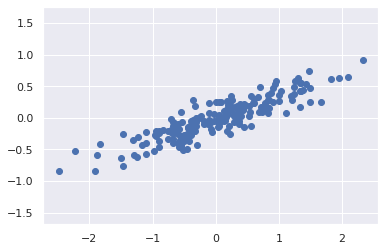

In [ ]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

### P.453

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [ ]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


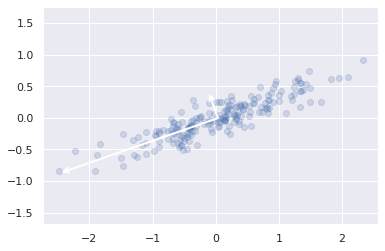

In [ ]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

### P.455

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [ ]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


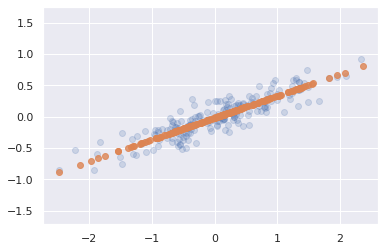

In [ ]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

### P.456

### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the digits data we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb).

We start by loading the data:

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

### P.457

In [ ]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


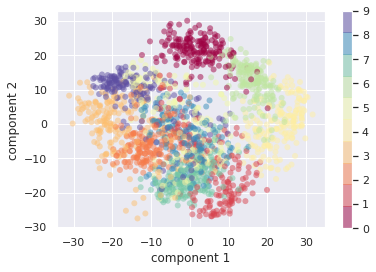

In [ ]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

### P.458

### What do the components mean?

We can go a bit further here, and begin to ask what the reduced dimensions *mean*.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.
This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

### P.459

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components:

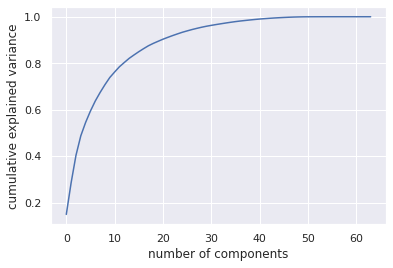

In [ ]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### P.460

## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free data:

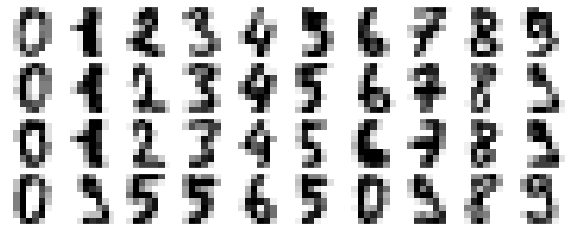

In [ ]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

### P.461

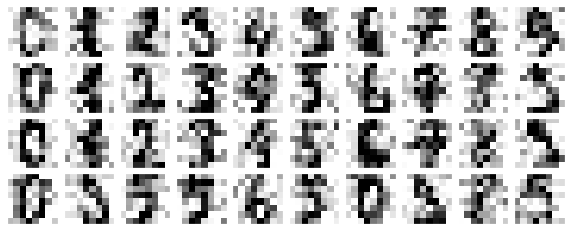

In [ ]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

In [ ]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

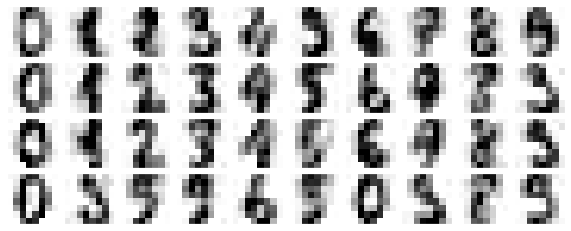

In [ ]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

### P.462

## Example: Eigenfaces

Earlier we explored an example of using a PCA projection as a feature selector for facial recognition with a support vector machine (see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we will take a look back and explore a bit more of what went into that.
Recall that we were using the Labeled Faces in the Wild dataset made available through Scikit-Learn:

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

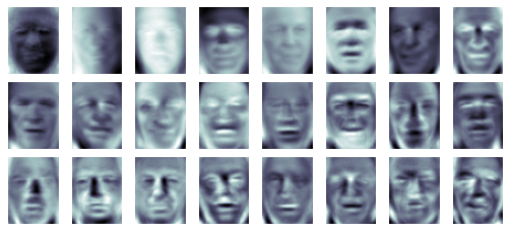

In [ ]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

### P.463

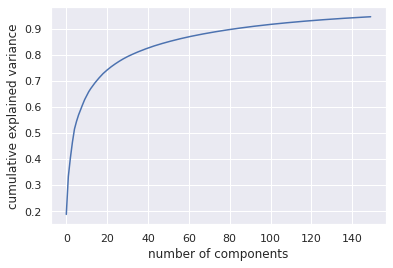

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### P.464

In [ ]:
# Compute the components and projected faces
pca = PCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

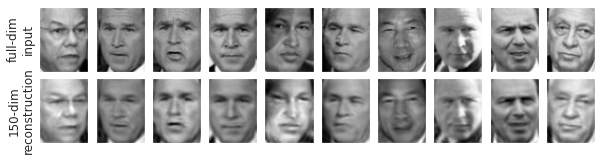

In [ ]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

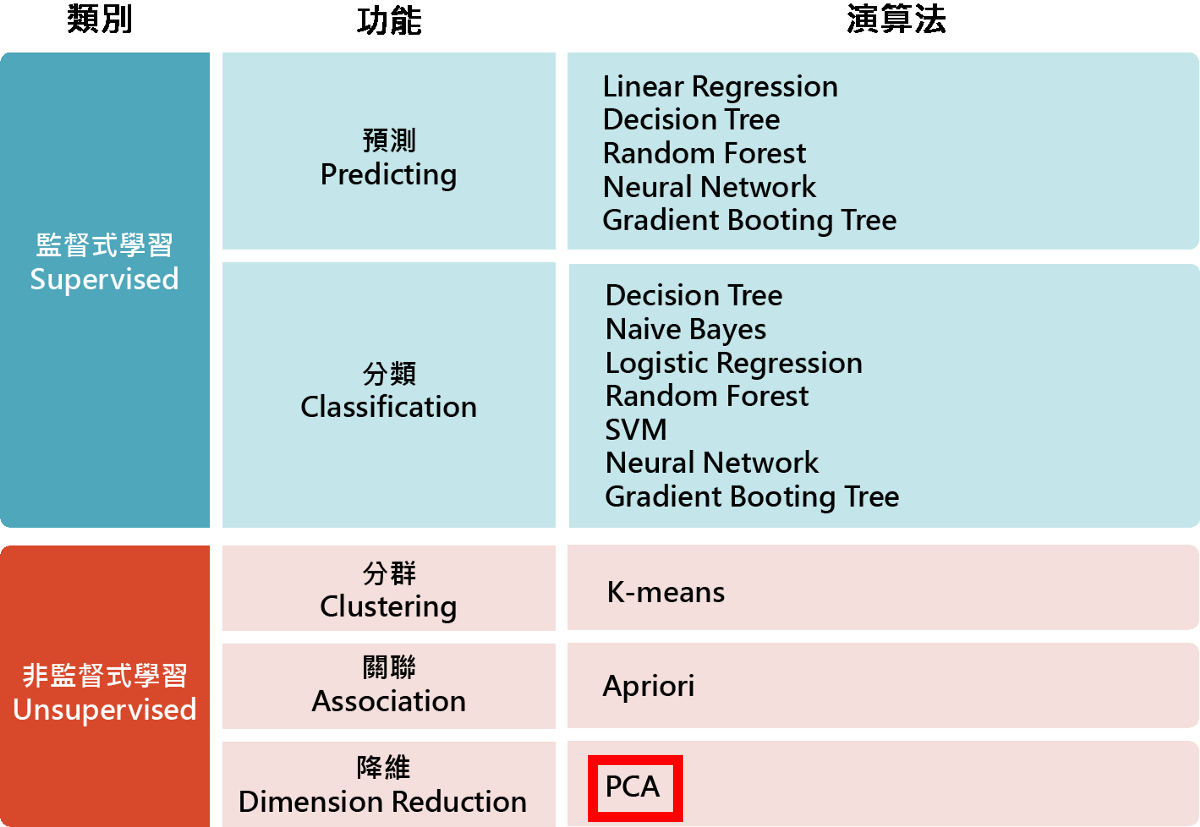

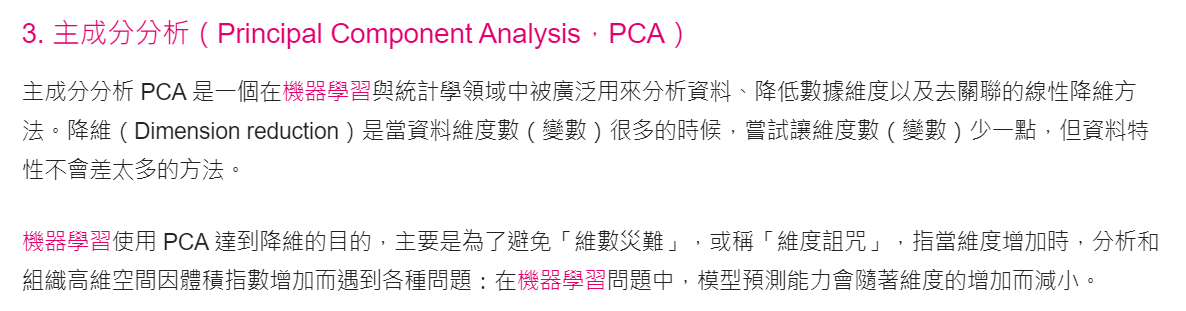

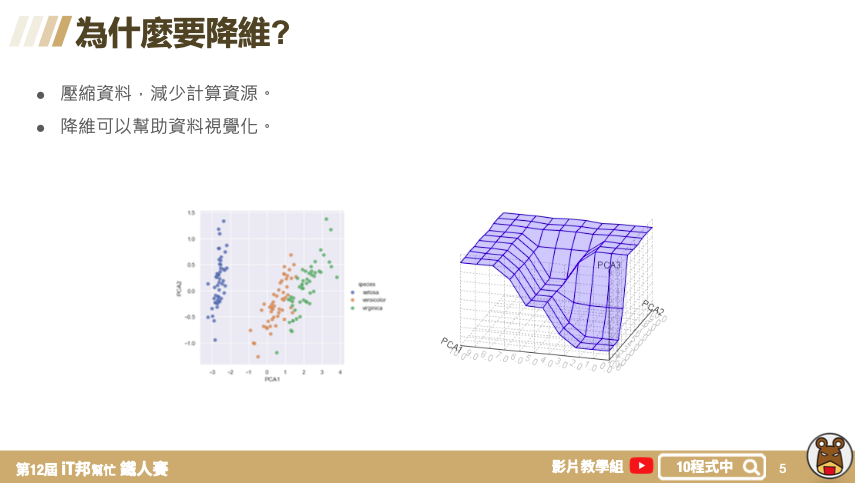

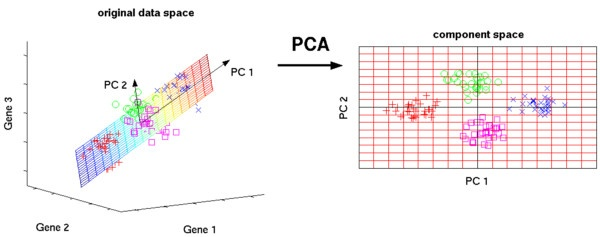

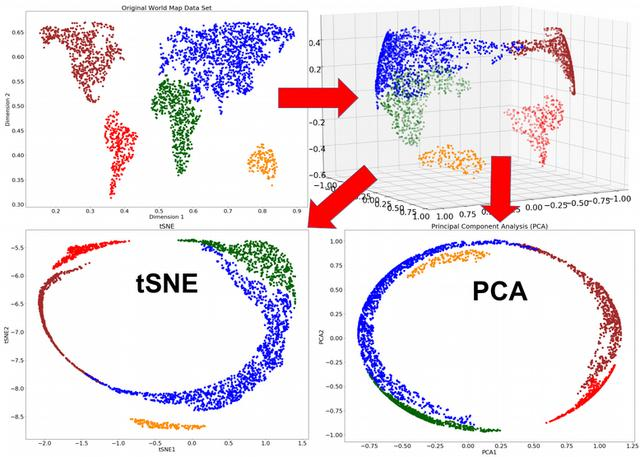

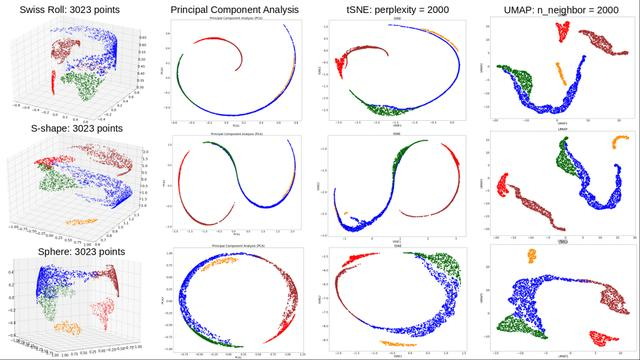